In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('kobe.csv')
data.shape

(30697, 25)

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [5]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [6]:
data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


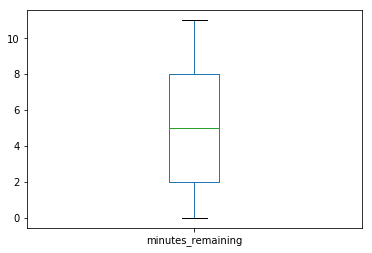

In [7]:
data.minutes_remaining.plot(kind='box')

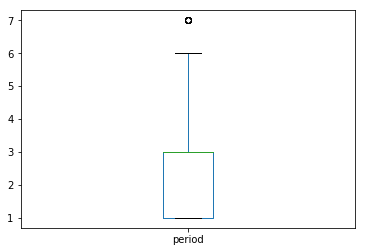

In [8]:
data.period.plot(kind='box')

In [9]:
data.shot_made_flag.value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

In [10]:
data.period.value_counts()

3    8296
1    8048
4    7260
2    6718
5     330
6      38
7       7
Name: period, dtype: int64

In [11]:
data.team_name.value_counts()

Los Angeles Lakers    30697
Name: team_name, dtype: int64

In [12]:
data.team_id.value_counts()

1610612747    30697
Name: team_id, dtype: int64

In [13]:
data.shot_type.value_counts()

2PT Field Goal    24271
3PT Field Goal     6426
Name: shot_type, dtype: int64

In [14]:
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek']    = data['game_date_DT'].dt.dayofweek
data['dayOfYear']    = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 \
+ (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) \
+ data['secondsFromPeriodStart']

In [15]:
data.drop(['team_name', 'team_id'], axis= 1, inplace = True)

In [16]:
data = data.fillna('na')

In [17]:
df = data[data['shot_made_flag']!='na']

In [18]:
df_predict = data[data['shot_made_flag']=='na']

In [19]:
df['matchup'] = df['matchup'].str.replace('@', 'vs.')
df_predict['matchup'] = df_predict['matchup'].str.replace('@', 'vs.')
df.shot_made_flag= df.shot_made_flag.astype('int64')

In [20]:
df.matchup.value_counts()

LAL vs. SAS    1618
LAL vs. PHX    1472
LAL vs. HOU    1399
LAL vs. SAC    1397
LAL vs. DEN    1352
LAL vs. POR    1292
LAL vs. UTA    1223
LAL vs. MIN    1219
LAL vs. GSW    1143
LAL vs. LAC    1074
LAL vs. DAL    1033
LAL vs. MEM     871
LAL vs. BOS     783
LAL vs. SEA     694
LAL vs. IND     626
LAL vs. ORL     604
LAL vs. PHI     603
LAL vs. DET     587
LAL vs. NYK     566
LAL vs. OKC     561
LAL vs. TOR     556
LAL vs. MIA     517
LAL vs. CHI     516
LAL vs. CLE     514
LAL vs. MIL     507
LAL vs. WAS     501
LAL vs. NOH     475
LAL vs. ATL     438
LAL vs. NJN     422
LAL vs. CHA     365
LAL vs. VAN     204
LAL vs. NOK     196
LAL vs. CHH     135
LAL vs. NOP      91
LAL vs. PHO      63
LAL vs. BKN      45
LAL vs. SAN      20
LAL vs. UTH      15
Name: matchup, dtype: int64

In [21]:
df.opponent.value_counts()

SAS    1638
PHX    1535
HOU    1399
SAC    1397
DEN    1352
POR    1292
UTA    1238
MIN    1219
GSW    1143
LAC    1074
DAL    1033
MEM     871
BOS     783
SEA     694
IND     626
ORL     604
PHI     603
DET     587
NYK     566
OKC     561
TOR     556
MIA     517
CHI     516
CLE     514
MIL     507
WAS     501
CHA     500
NOH     475
ATL     438
NJN     422
NOP     287
VAN     204
BKN      45
Name: opponent, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 29 columns):
action_type               25697 non-null object
combined_shot_type        25697 non-null object
game_event_id             25697 non-null int64
game_id                   25697 non-null int64
lat                       25697 non-null float64
loc_x                     25697 non-null int64
loc_y                     25697 non-null int64
lon                       25697 non-null float64
minutes_remaining         25697 non-null int64
period                    25697 non-null int64
playoffs                  25697 non-null int64
season                    25697 non-null object
seconds_remaining         25697 non-null int64
shot_distance             25697 non-null int64
shot_made_flag            25697 non-null int64
shot_type                 25697 non-null object
shot_zone_area            25697 non-null object
shot_zone_basic           25697 non-null object
shot_zone_range           25697 non

In [23]:
df.shape

(25697, 29)

In [24]:
df.season.value_counts()

2005-06    1924
2002-03    1852
2008-09    1851
2007-08    1819
2009-10    1772
2001-02    1708
2006-07    1579
2000-01    1575
2010-11    1521
2011-12    1416
2003-04    1371
2012-13    1328
1999-00    1312
2004-05    1127
2015-16     932
1997-98     810
1998-99     765
2014-15     593
1996-97     383
2013-14      59
Name: season, dtype: int64

In [25]:
def get_woe_v1(df_train,  col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    #df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train

In [26]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,game_date,matchup,opponent,shot_id,game_date_DT,dayOfWeek,dayOfYear,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2000-10-31,LAL vs. POR,POR,2,2000-10-31,1,305,622,98,98
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2000-10-31,LAL vs. POR,POR,3,2000-10-31,1,305,465,255,255
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2000-10-31,LAL vs. POR,POR,4,2000-10-31,1,305,412,308,308
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2000-10-31,LAL vs. POR,POR,5,2000-10-31,1,305,379,341,1061
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2000-10-31,LAL vs. POR,POR,6,2000-10-31,1,305,572,148,1588


In [27]:
df.shape

(25697, 29)

In [28]:
cat_col  = ['action_type', 'combined_shot_type', 'season', 'shot_type', 'shot_zone_area', \
            'shot_zone_basic', 'shot_zone_range', 'matchup', 'opponent', 'playoffs',\
            'period', 'loc_x', 'loc_y', 'lat', 'lon']

In [29]:
for col_get_prob in cat_col:
    df = get_woe_v1(df, col_get_prob, 'shot_made_flag')

In [30]:
df.shape

(25697, 44)

In [31]:
correct_cols = []
for x in df.columns.tolist():
    if x not in cat_col:
        correct_cols.append(x)

In [32]:
df = df[correct_cols]

In [33]:
corr = df.corr()
corr['shot_made_flag'].sort_values(ascending = False)

shot_made_flag            1.000000
action_type_woe           0.362737
combined_shot_type_woe    0.243923
lon_woe                   0.227857
loc_x_woe                 0.227857
lat_woe                   0.210633
loc_y_woe                 0.210633
shot_zone_basic_woe       0.202338
shot_zone_range_woe       0.180115
shot_zone_area_woe        0.140728
shot_type_woe             0.121462
season_woe                0.049758
matchup_woe               0.040865
period_woe                0.038364
opponent_woe              0.035722
seconds_remaining         0.030804
secondsFromPeriodEnd      0.030775
minutes_remaining         0.028342
playoffs_woe              0.001257
dayOfWeek                -0.000764
game_id                  -0.001612
dayOfYear                -0.004120
shot_id                  -0.013016
secondsFromPeriodStart   -0.030775
game_event_id            -0.037232
secondsFromGameStart     -0.038858
shot_distance            -0.198242
Name: shot_made_flag, dtype: float64

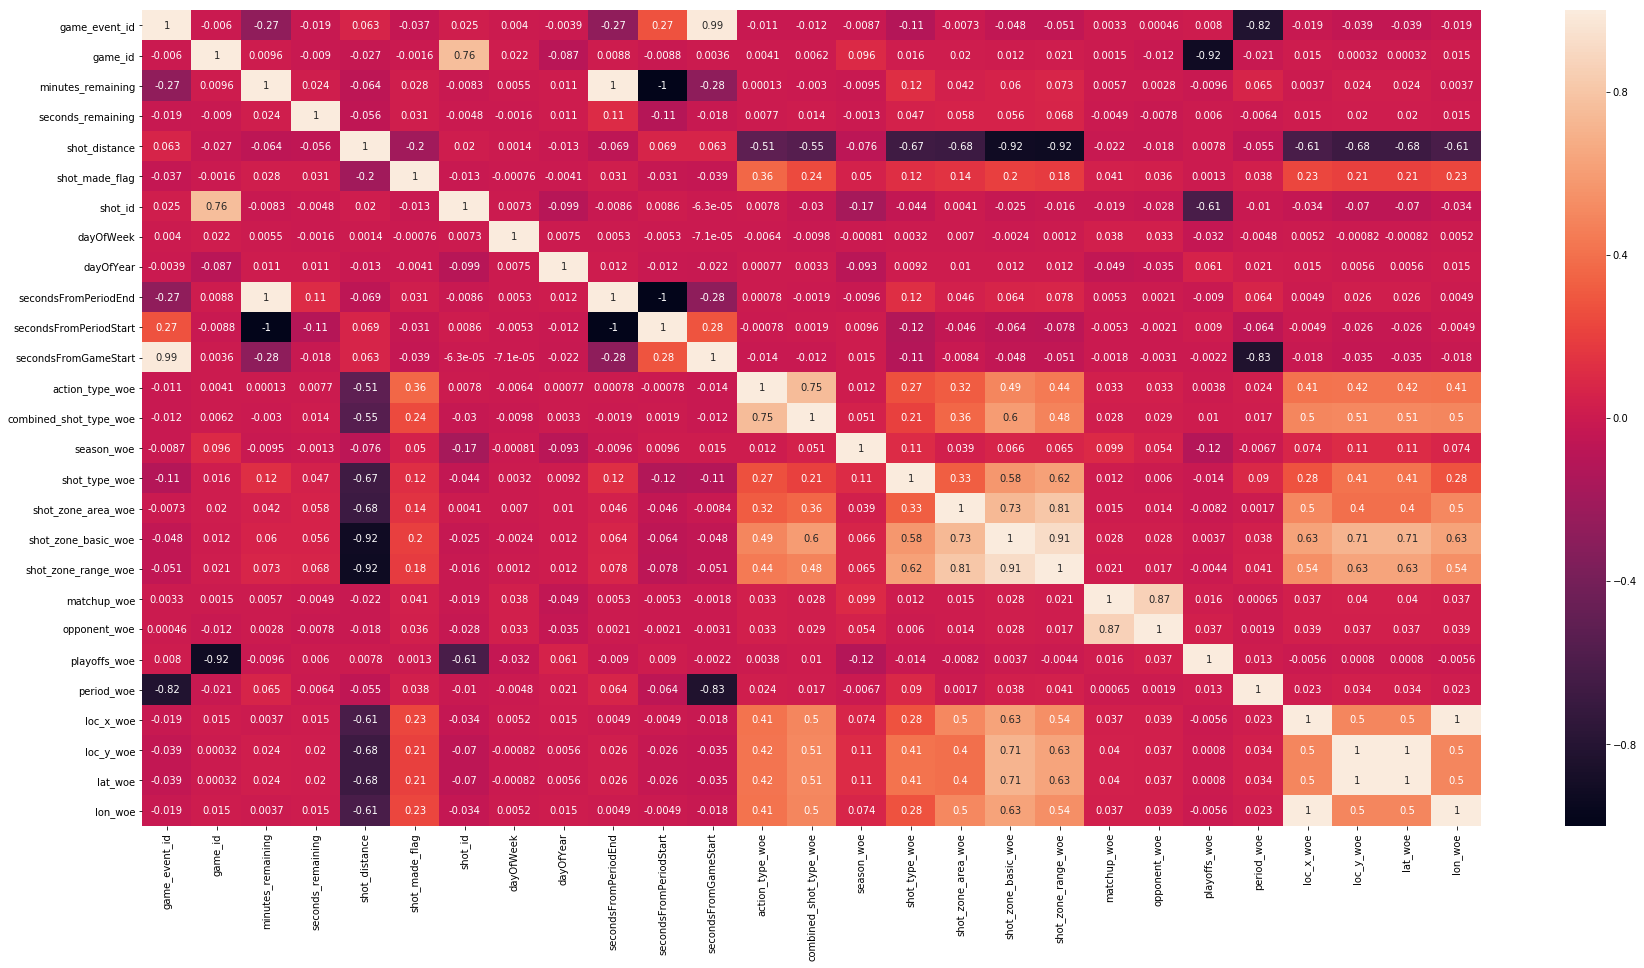

In [34]:
plt.subplots(figsize=(30,15))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f440c8080>,
      dtype=object)

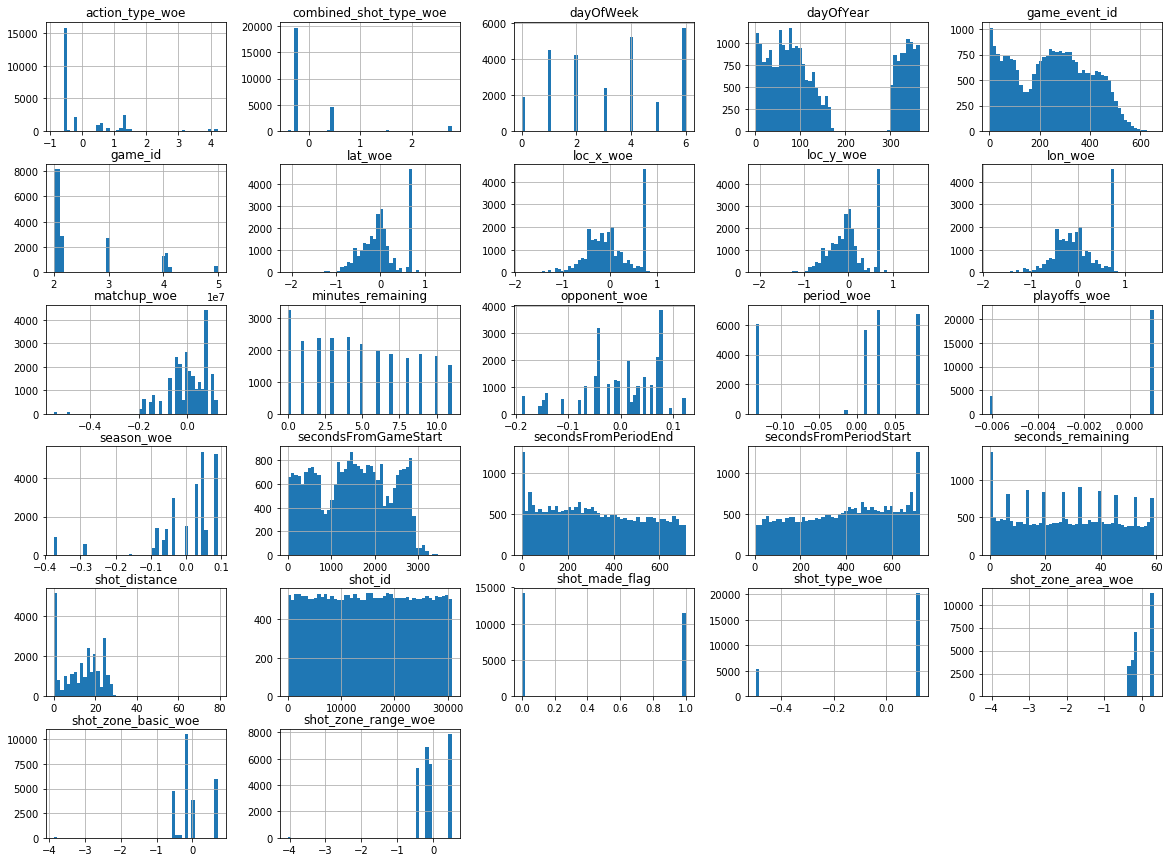

In [35]:
df.hist(bins=50, figsize=(20,15))

In [36]:
df['year'] = df.game_date.map(lambda x: x[0:4])

In [37]:
df = df.sort_values('year', ascending = False)
df.shape

(25697, 30)

In [38]:
df.drop(['year', 'game_date', 'game_date_DT'], axis = 1, inplace = True)
df = df.fillna(0)

In [39]:
df_test = df.head(int(df.shape[0]*0.2))

In [40]:
df_train = df.tail(int(df.shape[0]*0.8)+1)

In [41]:
df_train.shape[0]+df_test.shape[0]

25697

In [42]:
from sklearn.linear_model import LinearRegression

def linear_regression(X, y):
   
    
    # fit
    linreg = LinearRegression(normalize=True)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    
    
    # Return the result in pre-defined format
    rss = sum((y_pred - y) ** 2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret, linreg

In [43]:
y = df_train['shot_made_flag']
X = df_train.drop('shot_made_flag', axis=1)
y_test = df_test['shot_made_flag']
X_test = df_test.drop('shot_made_flag', axis=1)

In [44]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [45]:
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [46]:
res, linreg  = linear_regression(X, y)

In [47]:
col = ['rss', 'intercept'] + ['coef_x_%d' % i for i in range(1, 16)]

In [48]:
print("RSS:", res[0])

RSS: 4280.320185437214


In [49]:
for i in range(2,len(res)-2):
    print("coeff_{}: {:f}".format(i, res[i]))

coeff_2: -0.005458
coeff_3: 0.006233
coeff_4: 0.004427
coeff_5: 0.012873
coeff_6: 0.124818
coeff_7: -0.003580
coeff_8: -0.002759
coeff_9: -0.000875
coeff_10: 0.005473
coeff_11: -0.005473
coeff_12: 0.001002
coeff_13: 0.223161
coeff_14: -0.074934
coeff_15: 0.011245
coeff_16: 0.015196
coeff_17: 0.006587
coeff_18: 0.006338
coeff_19: 0.050209
coeff_20: 0.013503
coeff_21: -0.004476
coeff_22: 0.005845
coeff_23: 0.012101
coeff_24: 0.032929
coeff_25: 0.023908


In [50]:
from sklearn.linear_model import Ridge

def ridge_regression(X, y, alpha):
    # Fit
    ridgereg = Ridge(alpha=alpha, normalize=True)
    ridgereg.fit(X, y)
    y_pred = ridgereg.predict(X)
    
    
    # format
    rss = sum((y_pred-y) ** 2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret, ridgereg

In [51]:
res, ridgereg  = ridge_regression(X, y, 0.005)

In [52]:
print("RSS:", res[0])

RSS: 4280.598940384574


In [53]:
for i in range(2,len(res)-2):
    print("coeff_{}: {:f}".format(i, res[i]))

coeff_2: -0.004482
coeff_3: 0.004531
coeff_4: 0.004424
coeff_5: 0.012759
coeff_6: 0.114535
coeff_7: -0.002933
coeff_8: -0.002680
coeff_9: -0.000920
coeff_10: 0.005460
coeff_11: -0.005460
coeff_12: -0.000140
coeff_13: 0.219114
coeff_14: -0.071590
coeff_15: 0.011182
coeff_16: 0.014549
coeff_17: 0.008191
coeff_18: 0.004149
coeff_19: 0.043267
coeff_20: 0.013199
coeff_21: -0.004052
coeff_22: 0.004727
coeff_23: 0.011843
coeff_24: 0.032219
coeff_25: 0.023349


In [54]:
from sklearn.linear_model import Lasso

def lasso_regression(X, y, alpha):
    # fit
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(X, y)
    y_pred = lassoreg.predict(X)
    
    
    # format
    rss = sum((y_pred-y) ** 2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret, lassoreg

In [55]:
res, lassoreg  = lasso_regression(X, y, 0.00002)

In [56]:
print("RSS:", res[0])

RSS: 4292.046186787404


In [57]:
for i in range(2,len(res)-2):
    print("coeff_{}: {:f}".format(i, res[i]))

coeff_2: -0.001017
coeff_3: -0.000096
coeff_4: 0.000000
coeff_5: 0.009725
coeff_6: 0.053451
coeff_7: -0.000000
coeff_8: -0.000000
coeff_9: -0.000000
coeff_10: 0.013315
coeff_11: -0.000000
coeff_12: -0.003753
coeff_13: 0.207648
coeff_14: -0.060013
coeff_15: 0.008956
coeff_16: 0.005959
coeff_17: 0.010110
coeff_18: 0.000000
coeff_19: 0.004119
coeff_20: 0.007684
coeff_21: 0.000000
coeff_22: 0.000000
coeff_23: 0.008970
coeff_24: 0.053884
coeff_25: 0.035438


In [58]:
y_train_predict = linreg.predict(X)
y_test_predict = linreg.predict(X_test)

In [59]:
roc_auc_train = np.round(roc_auc_score(y, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.7198
Test:  0.7048


In [60]:
y_train_predict = ridgereg.predict(X)
y_test_predict = ridgereg.predict(X_test)

In [61]:
roc_auc_train = np.round(roc_auc_score(y, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.7196
Test:  0.706


In [62]:
y_train_predict = lassoreg.predict(X)
y_test_predict = lassoreg.predict(X_test)

In [63]:
roc_auc_train = np.round(roc_auc_score(y, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.7172
Test:  0.711


Text(0,0.5,'explained_variance_ratio_')

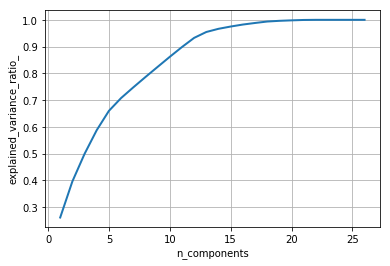

In [64]:
pca = PCA().fit(X)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [68]:
pca.components_

array([[ 3.75391271e-02,  4.09213312e-03, -4.14083884e-02,
        -2.36365607e-02,  3.56830327e-01,  6.57843401e-03,
         1.21773793e-03, -8.15807991e-03, -4.31359301e-02,
         4.31359301e-02,  3.95277355e-02, -2.44797347e-01,
        -2.68227997e-01,  5.92819305e-03, -2.21340119e-01,
        -2.69184121e-01, -3.58183337e-01, -3.36881275e-01,
        -1.78200025e-02, -1.84730926e-02, -9.23209806e-03,
        -3.12743276e-02, -3.01636412e-01, -3.03927229e-01,
        -3.03927229e-01, -3.01636412e-01],
       [ 3.85630359e-01,  9.52096644e-04, -4.45032060e-01,
        -4.68973328e-02, -1.11842906e-02,  4.22587771e-03,
        -1.71488272e-03, -7.05303998e-03, -4.46350493e-01,
         4.46350493e-01,  3.89943441e-01,  5.06982066e-02,
         6.11191631e-02, -1.60027092e-02, -7.10438605e-02,
         2.71865360e-02,  2.30725552e-02,  5.34851134e-03,
         1.45751260e-03,  4.33027078e-03,  2.90878244e-03,
        -2.76015692e-01,  6.45407201e-02,  3.78955069e-02,
         3.78

In [70]:
xgb = xgboost.XGBClassifier(max_depth=5, random_seed = 42, n_jobs=10)
xgb.fit(X, y)
y_train_predict = xgb.predict_proba(X)[:, 1]
y_test_predict = xgb.predict_proba(X_test)[:, 1]

In [71]:
roc_auc_train = np.round(roc_auc_score(y, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.7851
Test:  0.7193
